In [1]:
# Initialization
import matplotlib.pyplot as plt
import numpy as np

# Importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# Import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
l = [1,5,7,10]

In [3]:
# Writing the integrers in binary representation

def int_to_bit(l):
    p = []
    for i in l:
        p.append(bin(i)[2:].zfill(4))
    return p

list_bit = int_to_bit(l)

print(list_bit)  

N = len(list_bit)

['0001', '0101', '0111', '1010']


In [4]:
# Finding integers whose binary representation is such that two adjacent bits are different

def ind_sol(l, N):
    p = []
    for i in range (len(l)):
        s = 0
        for k in range (len(l[0])-1):
            if l[i][k] != l[i][k+1]: 
                s+=1
        if s == N-1:
            p.append(i)
    return p

list_ind_sol = ind_sol(list_bit, N)

print(list_ind_sol)

[1, 3]


In [5]:
# Writing the indices of the integrers in binary representation

list_ind = [i for i in range(N)]

def ind_to_bit(l):
    p = []
    for i in l:
        p.append(bin(i)[2:].zfill(2))
    return p

list_ind_bit = ind_to_bit(list_ind)

print(list_ind_bit)

['00', '01', '10', '11']


We apply Grover's algorithm to create a quantum state which is a superposition of indices of the target solution :



In [6]:
# Initialising by applying a H-gate to 'qubits' in qc

def initialize_s(qc, qubits):
    for q in qubits:
        qc.h(q)
    return qc

In [7]:
# Creating a phase oracle

def oracle2(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.z(0)
    O = qc.to_gate()
    O.name = "U$_\omega$"
    return O

In [8]:
# Diffusion operator (U_s) for n qubits

def diffuser(nqubits): 
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    qc.draw('mpl')
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [9]:
# Diffusion operator (U_s2) for 2 qubits

def diffuser2(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.h([0,1])
    qc.z([0,1])
    qc.cz(0,1)
    qc.h([0,1])
    qc.draw('mpl')
    U_s2 = qc.to_gate()
    U_s2.name = "U$_s2$"
    return U_s2

We will first try Grover's algorithm for N=4 which is realized with 2 qubits. We want to create a quantum state which is a superposition of two indices of the target solution 01 and 11

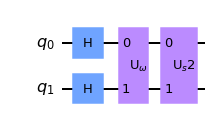

In [10]:
# Grover's algorithm first implementation

n = 2
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.append(oracle2(n), [0,1])
grover_circuit.append(diffuser2(n), [0,1])
grover_circuit.draw('mpl')

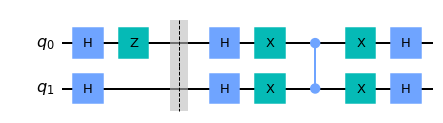

In [11]:
# Grover's algorithm second implementation

n = 2
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1])
# Oracle
grover_circuit.z(0) 
grover_circuit.barrier()
# Diffusion operator U_s2
grover_circuit.h([0,1]) 
grover_circuit.x([0,1])
grover_circuit.cz(0,1)
grover_circuit.x([0,1])
grover_circuit.h([0,1])

grover_circuit.draw('mpl')

In [12]:
sim = Aer.get_backend('aer_simulator')
# Make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()
qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()

print(statevec)

[ 0.5-1.2246468e-16j -0.5+6.1232340e-17j  0.5-1.8369702e-16j
 -0.5+1.2246468e-16j]


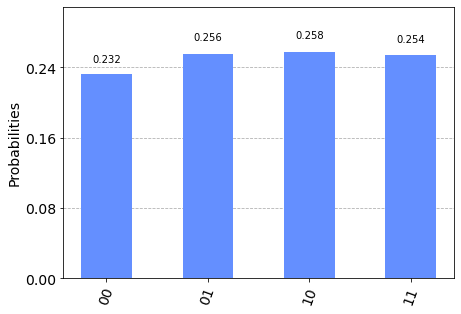

In [13]:
grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)


Now we will try Grover's algorithm for N=8 which is realized with 3 qubits. We want to create a quantum state which is a superposition of two indices 010 and 110

In [14]:
# Creating a phase oracle

def oracle3(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.cz(0,1)
    qc.x(0)
    O3 = qc.to_gate()
    O3.name = "U$_\omega3$"
    return O3

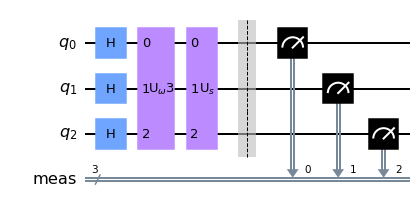

In [15]:
# Grover's algorithm implementation

n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle3(n), [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw('mpl')

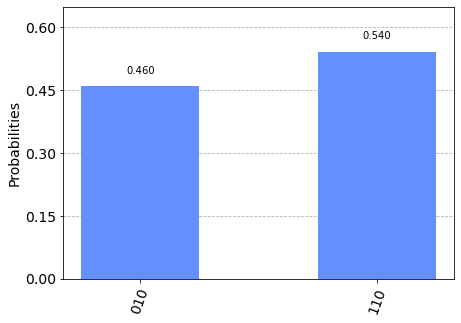

In [16]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)